<a href="https://colab.research.google.com/github/himanshuJan07/KityHelloWorld/blob/master/classification_with_data_ag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!git clone https://github.com/himanshuJan07/birds_dataset.git

#!cd birds_dataset/

!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 4.8MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [ ]:
#from pyunpack import Archive
#Archive('/content/drive/birds.rar').extractall('')

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from keras.preprocessing import image_dataset_from_directory

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

training_dataset = image_dataset_from_directory('/content/drive/My Drive/birds/Training', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('/content/drive/My Drive/birds/Validation', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2457 files belonging to 5 classes.
Found 142 files belonging to 5 classes.


In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

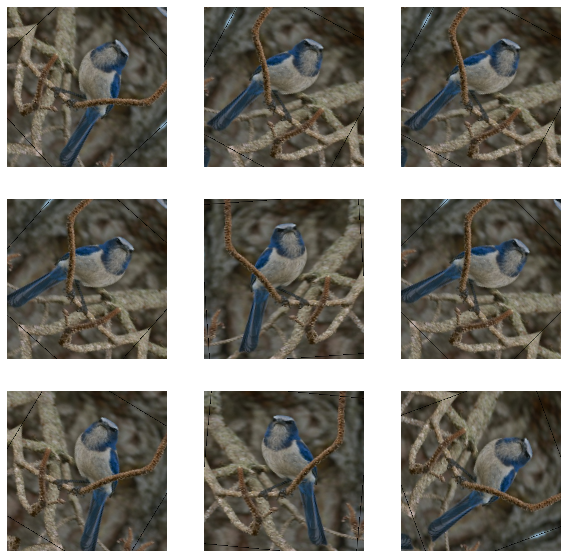

In [14]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(training_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [43]:
base_model.trainable = True
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [53]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [54]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [55]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

77/77 [==============================] - 12s 154ms/step - loss: -786.4667 - accuracy: 0.3455


In [61]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -786.47
initial accuracy: 0.35


In [ ]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: -912.8629 - accuracy: 0.3455

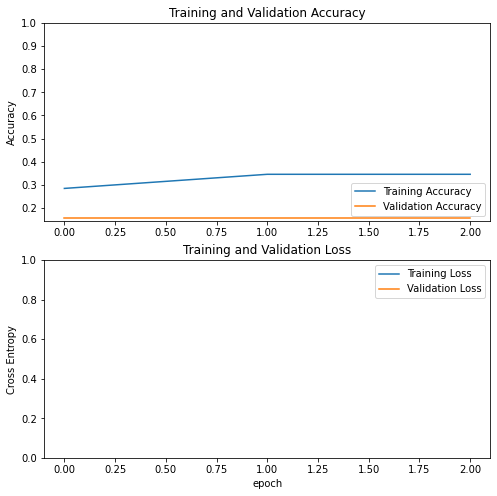

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()